<a href="https://colab.research.google.com/github/cwieder/SymbNET_tutorial/blob/main/SymbNET_Pathway_Analysis_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SymbNET Metabolomics Workshop for Biologists
## Metabolomics pathway analysis tutorial: functional enrichment methods, databases, and visualisation

### University of Lausanne, Lausanne, Switzerland
#### Cecilia Wieder and Prof. Tim Ebbels (Imperial College London)

Use this tutorial to gain a deeper understanding of how metabolomics pathway analysis is implemented. You can re-use any of the code in this notebook on your own data. Sections that may be relevant to processing your own dataset but are not key to this tutorial are commented out.

**Figure: Overview of pathway analysis methods.** In this tutorial we will focus on conventional methods Over-Representation Analysis (ORA) and Gene Set Enrichment Analysis (GSEA), as well as single-sample pathway analysis (ssPA). 

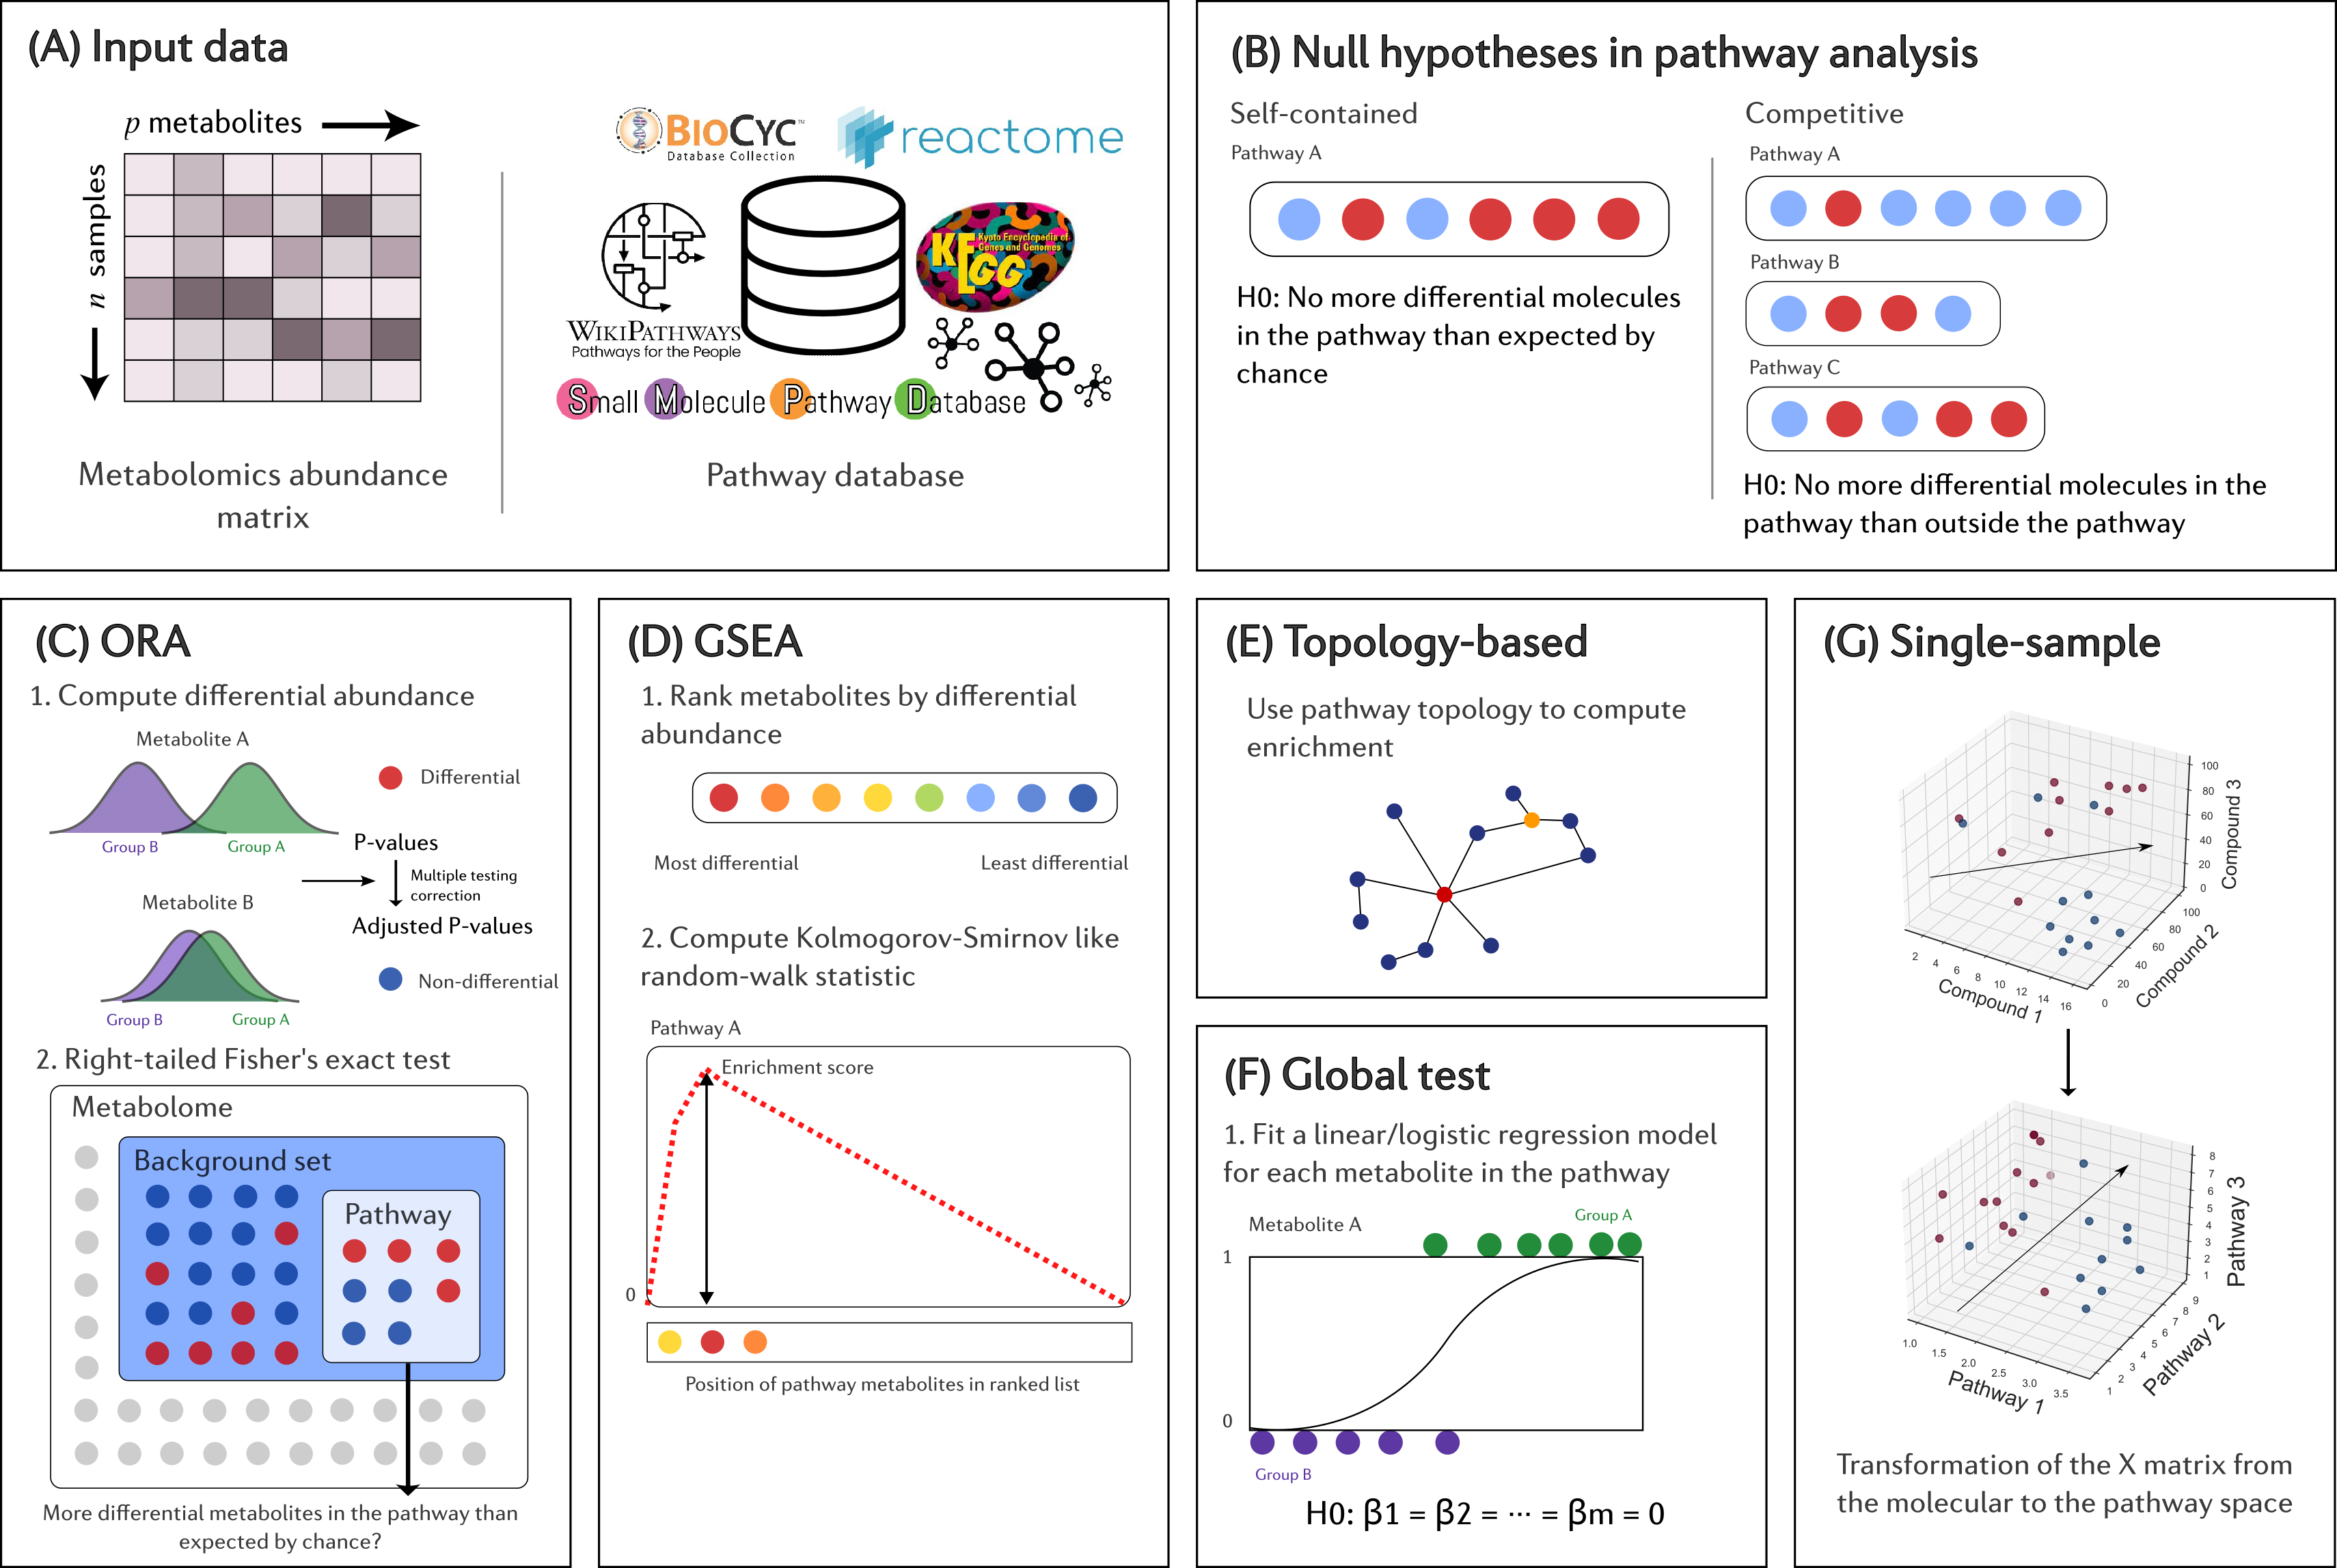

### Installing and importing required packages
Please run all the cells in this section to ensure the following cells run smoothly

Install [sspa](https://cwieder.github.io/py-ssPA/) and [gseapy](https://gseapy.readthedocs.io/en/latest/introduction.html)

In [ ]:
!pip install sspa gseapy

Import requried python packages

In [ ]:
# For general data science and matrix manipulation
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy import stats

# For pathway analysis in python
import sspa
import gseapy

# For plotting 
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# For network creation and visualisation
import networkx as nx

## Load and process metabolomics data

All pathway analysis methods require at least a dataset and a set of pathways. First we are going to import the metabolomics dataset we will be working with. It is important to ensure the data has been processed prior to pathway analysis. This can include:
1. Sample normalisation (e.g. Probabilistic Quotient Normalisation)
2. Missing value imputation
3. Log2 transformation
4. Centering and scaling the features to unit variance (mean = 0 and standard deviation = 1)
5. Outlier detection (e.g. using PCA)

For more details about pre-processing metabolomics data, see here: https://www.intechopen.com/books/metabolomics-fundamentals-and-applications/processing-and-visualization-of-metabolomics-data-using-r


The dataset we will be working with is from **Su et al. "Multi-Omics Resolves a Sharp Disease-State Shift between Mild and Moderate COVID-19".** It is an untargeted mass spectrometry dataset generated by Metabolon containing 133 COVID-19 plasma samples of varying WHO ordinal scale severity and 133 control plasma samples. A total of 1050 compounds were profiled.

Su Y, Chen D, Yuan D, Lausted C, Choi J, Dai CL, et al. Multi-Omics Resolves a Sharp Disease-State Shift between Mild and Moderate COVID-19. Cell. 2020;183: 1479-1495.e20. [doi:10.1016/j.cell.2020.10.037](doi:10.1016/j.cell.2020.10.037)

In [ ]:
covid_data = sspa.load_example_data(omicstype="metabolomics", processed=False)

Look at the metadata class distribution - for conventional methods we will be using the Group column as it contains two groups: healthy donor and COVID19

In [ ]:
covid_data['Group'].value_counts()

In [ ]:
covid_data['WHO_status'].value_counts()

In [ ]:
# Keep only metabolites (exclude metadata columns)
covid_values = covid_data.iloc[:, :-2]

# Remove features with too many na values
data_filt = covid_values.loc[:, covid_values.isin([' ', np.nan, 0]).mean() < 0.5]

# Impute using the median
imputed_mat = data_filt.fillna(data_filt.median())

# Log transform the data
log2_mat = np.log2(imputed_mat)

# Standardise the data
processed_data = pd.DataFrame(StandardScaler().fit_transform(log2_mat), columns=imputed_mat.columns, index=imputed_mat.index)

In [ ]:
processed_data.head()

The mean of the metabolites is now around 0 which is important for methods using PCA such as single-sample pathway analysis.

In [ ]:
processed_data.mean().head()

Check for signal or clustering in the data using PCA

In [ ]:
PCA_covid = PCA(n_components=2)
PCA_scores = pd.DataFrame(PCA_covid.fit_transform(processed_data), columns=['PC1', 'PC2'], index=covid_data.index)
PCA_scores['WHO_status'] = covid_data['WHO_status'].values
PCA_scores['Group'] = covid_data['Group'].values

In [ ]:
PCA_scores.head(5)

In [ ]:
sns.set_style('darkgrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

sns.scatterplot(
    data=PCA_scores,
    x='PC1',
    y='PC2',
    hue='Group',
    linewidth=0.5,
    edgecolor='k',
    s=50,
    # palette='Reds',
    # hue_order=['0', '1-2', '3-4', '5-7'],
    ax=ax1
)

sns.scatterplot(
    data=PCA_scores,
    x='PC1',
    y='PC2',
    hue='WHO_status',
    linewidth=0.5,
    edgecolor='k',
    s=50,
    palette='Reds',
    hue_order=['0', '1-2', '3-4', '5-7'],
    ax=ax2
)
plt.show()

OPTIONAL: Save the processed data to .csv format

In [ ]:
# processed_data.to_csv("example_covid_data_processed.csv")

Alternatively, to load the pre-processed dataset, set the argument "processed" to True

In [ ]:
# covid_data_processed = sspa.load_example_data(omicstype="metabolomics", processed=True)

### Loading your own dataset

The easiest way to load your own metabolomics dataset to use with sspa is to use the pandas.read_csv() function to read in the CSV file. You can also read in sample metadata as part of the same file, or as a separate file, as long as all metadata is in the form of pandas Series/DataFrame columns. 

In [ ]:
# my_metabolomics_data = pd.read_csv("path/to/inputdata.csv")

## Identifier harmonisation

To map compounds in the metabolomics data to those in pathways, we must ensure the metabolite IDs in the data match those in the pathway database used. 

The MetaboAnalyst (Pang et al., 2021) ID conversion tool can convert to and from many input formats including compound names, HMDB ID, KEGG ID, PubChem, ChEBI, and METLIN. In this protocol we will be using the sspa.identifier_conversion() functions to retrieve the compound mapping from the MetaboAnalyst API, but this can also be done using the GUI (https://www.metaboanalyst.ca/MetaboAnalyst/upload/ConvertView.xhtml). 

This step can take several minutes depending on how many identifiers you wish to convert. 


The output ID can be any of:
- name - Compound name (e.g., 1,3-Diaminopropane)
- hmdb - Human Metabolome Database (e.g., HMDB0000002)
- pubchem - PubChem Substance and Compound databases(e.g., 428)
- chebi - Chemical Entities of Biological Interest(e.g., 15725)
- metlin - Metabolite and Chemical Entity Database (e.g., 5081)
- kegg - KEGG COMPOUND Database (e.g., C00986)

First we will create a compound ID conversion table using the sspa.identifier_conversion(input_type, identifier_list) function. This function takes two arguments, the first is the input identifier type (see Table 4 of the protocol for possible inputs), and a list of compound names/identifiers. The example COVID metabolomics data has compound names as identifiers, so we will specify the ‘input_type’ argument as ‘name’. 

**CRITICAL**: It is highly recommended to check that the input identifiers (‘identifier_list’) are clean and do not contain anomalies such as semicolons ‘;’ which may result in spurious matches or errors in the identifier conversion module. 


Use the identifier_conversion function to get identifier mappings. Change the input_type argument to the type of compound identifier you are converting from. 

❗**This step may take a few minutes to complete - so we will try it on a subset of 10 compounds from the dataset and load the full conversion table from a .csv file later. **

In [ ]:
compound_names = processed_data.columns.tolist()

# tiny example with 10 compounds
conversion_table_tiny = sspa.identifier_conversion(input_type="name", compound_list=compound_names[0:10])

In [ ]:
conversion_table_tiny

Now let's load the full conversion table which has been pre-compputed to save time:

In [ ]:
conversion_table = pd.read_csv('https://raw.githubusercontent.com/cwieder/SymbNET_tutorial/main/conversion_table_COVID.csv', dtype='object')

Count how many identifiers have matches

In [ ]:
conversion_table["Comment"].value_counts()

OPTIONAL: export conversion table as a .csv file, manually update missing identifiers and re-upload the conversion table to proceed with the ID mapping step

**Only run the following two cells if you wish to manually edit the ID matching results**

In [ ]:
#conversion_table.to_csv("conversion_table.csv")

In [ ]:
#conversion_table = pd.read_csv("conversion_table.csv", index_col=0, dtype=object)

Troubleshooting: If difficulty is experienced in obtaining the ID conversion table (API error), please use the [MetaboAnalyst web interface](https://www.metaboanalyst.ca/MetaboAnalyst/upload/ConvertView.xhtml) and upload the resulting conversion table .csv file (called name_map.csv by default) to continue with the rest of the tutorial:



In [ ]:
# conversion_table = pd.read_csv("name_map.csv", index_col=0, dtype=object)

We can then use the sspa.map_identifiers(conversion_table, output_id_type, data_matrix) function to convert the identifiers in our dataset. We must specify three arguments to the function: the conversion table generated in the previous step, the output ID type, and the matrix containing the metabolomics data. This function will return the metabolomics data matrix with mapped identifiers.

In [ ]:
processed_data_mapped = sspa.map_identifiers(conversion_table, output_id_type="ChEBI", matrix=processed_data)

In [ ]:
processed_data_mapped.head()

## Importing pathways

Sspa comes with pre-loaded versions of Reactome (all supported organisms) release 78 (2022) and KEGG (human) release 98 (2022). It also allows users to easily download the latest version of KEGG and Reactome (all supported organisms). Users can also provide their own pathway files, as long as they are in GMT format. 

The sspa package has several functions for processing data for different databases. These are:
-	Process_reactome(organism, infile=None, download_latest=False, filepath=None)
-	Process_kegg(organism, infile=None, download_latest=False, filepath=None)
-	Process_gmt(infile) - load files in GMT format, ending in .gmt or .csv extension

For KEGG and Reactome, you will need to specify the organism code/name in the function call. KEGG 3-letter organism codes e.g. “hsa”, “mmu”, can be found at http://rest.kegg.jp/list/organism. Reactome organism names e.g. “Homo sapiens”, “Mus musculus”, can be found at https://reactome.org/content/schema/objects/Species. 


### Using pre-loaded pathway databases

Import the pre-loaded Reactome metabolic pathways (Release 78)

In [ ]:
# We will import the metabolite pathways from the Reactome database
# We must specify one of the Reactome organism names
# This returns a GMT format pandas DataFrame containing the pathway information
reactome_pathways  = sspa.process_reactome(organism="Homo sapiens")

In [ ]:
kegg_human_pathways  = sspa.process_kegg(organism="hsa")

In [ ]:
reactome_pathways.head()

This CSV/GMT pathway file contains:
- **Index column**: contians the pathway identifiers
- **Pathway name column**: contains the pathway names
- **Compound columns**: Each row of the file contains columns each containing the compound identifiers for each pathway

In [ ]:
kegg_human_pathways.head()

### (OPTIONAL) Specifying your own pathways (in GMT format)

Here we load the latest release of WikiPathways by saving the .GMT file from the WikiPathways website and processing it usign the sspa process_gmt function. 

NOTE: A list of current WikiPathways GMT files and urls can be found [here](https://wikipathways-data.wmcloud.org/current/gmt/)

In [ ]:
# import urllib.request

# wikipathways_url = "https://wikipathways-data.wmcloud.org/20221110/gmt/wikipathways-20221110-gmt-Homo_sapiens.gmt"

# urllib.request.urlretrieve(wikipathways_url, "wikipathways-20221110-gmt-Homo_sapiens.gmt")

# # load the GMT file using sspa
# custom_pathways = sspa.process_gmt("wikipathways-20221110-gmt-Homo_sapiens.gmt")

In [ ]:
# custom_pathways

### (OPTIONAL) Downloading latest versions of KEGG and Reactome databases

### Download latest KEGG pathways

In [ ]:
# kegg_mouse_latest = sspa.process_kegg("mmu", download_latest=True, filepath=".")

### Download latest Reactome pathways

In [ ]:
# # download Reactome latest
# reactome_mouse_latest = sspa.process_reactome("Mus musculus", download_latest=True, filepath=".")

In [ ]:
# reactome_mouse_latest.head()

## Checking ID mappings
Check how many of the mapped compound identifiers are in the pathway database (i.e. annotated to a pathway):

In [ ]:
## if using Reactome database as the pathway database
# count all compounds in the dataset
print(len(compound_names), "compounds in the dataset")

# find how many input compound names in the dataset had a matching ChEBI ID
chebi_matches = conversion_table[(conversion_table["Comment"] == "1") & (conversion_table["ChEBI"].isnull()==False)]["ChEBI"]
print(len(chebi_matches), "compounds from the dataset that have ChEBI IDs")

# count all unique compounds in the Reactome database
all_reactome_cpds = set(sum(sspa.utils.pathwaydf_to_dict(reactome_pathways).values(), []))
print(len(all_reactome_cpds), "total unique compounds in Reactome")

# find the intesect between all reactome compounds and all ChEBI IDs annotated to the dataset
mapped_annotated_cpds = set(processed_data_mapped.columns) & all_reactome_cpds
print(len(mapped_annotated_cpds), "compounds present in both the dataset and Reactome pathways")

Visualise this in barchart form:

In [ ]:
sns.set_context('notebook')
sns.set_style('ticks')
sns.barplot(
    y=[len(compound_names), len(chebi_matches), len(mapped_annotated_cpds)], 
    x=['Original', 'Mapping to CHEBI', 'Mapping to ChEBI \n and annotated to Reactome']
    )
plt.tight_layout()
plt.show()

Or funnel plot...

In [ ]:
data = dict(count=[len(compound_names), len(chebi_matches), len(mapped_annotated_cpds)],
            label=['Original', 'Mapping to CHEBI', 'Annotated to Reactome'])

fig = px.funnel(data, x='count', y='label')
fig.show(renderer="colab")

Here we plot an interactive heatmap that shows which compounds have mapped to pathway database IDs, and those that are present in pathways. Hover over the plot or **zoom in** to see the compound names.

In [ ]:
import plotly.io as pio
pio.renderers.default = "notebook"

df = pd.DataFrame(compound_names, columns=['Original_ID'])
df["Matched_ID"] = df['Original_ID'].map(dict(zip(conversion_table["Query"], conversion_table["ChEBI"])))
df["In_pathway"] = [i if i in mapped_annotated_cpds else "NA" for i in df["Matched_ID"] ]
df = df.replace({"NA":0})
df[df != 0] = 1
df = df.astype("float")
df.index = compound_names

fig = px.bar(df)
fig.show(renderer="colab")

How many pathways contain at least two mapped compounds?

In [ ]:
# convert the pathway dataframe to dictionary - for faster calculations
# replace reactome_pathways with the variable containing the pathway dataframe being used
pathways_dict = sspa.utils.pathwaydf_to_dict(reactome_pathways)

# How many pathways contain at least two mapped compounds?
pathways_present = {k: v for k, v in pathways_dict.items() if len([i for i in processed_data_mapped.columns if i in v]) > 1}
print(len(pathways_present))

## Conventional pathway analysis methods

### ORA

Over-representation analysis is one of the commonest pathway analysis methods in metabolomics. It tests the ***competitive*** null hypothesis that a subset of compounds of interest (e.g. those differentially abundant between study groups) are no more present in a certain biological pathway than background compounds. 

We can build a 2-by-2 contingency table such as the one below, which differentiates between the number of compounds in the dataset which are in a pathway, those that are differentially abundant, and vice versa. 

<center>
<table><tr>
<td> <img src="https://drive.google.com/uc?id=1MFbzb8QUE70zwPZCKJJGVH8YPcqB4OVX" width="300px">  </td>
<td> <img src="https://drive.google.com/uc?id=1E0F70SBnnP8h6BTK_Wpb-Ie5fIBY44jC" width="350px"> </td>
</tr></table>
</center>

A test statistic and P-value can be determined for each pathway using this contingency table by using a **right-sided Fisher's exact test**. 

\begin{equation}
p = 1 - \sum_{i=0}^{k-1} \frac{\binom{M}{i}\binom{N-M}{n-i}}{\binom{N}{n}}
\end{equation}

The essential inputs of ORA are:
- **Background set** (N)
- **List of metabolites of interest** (n)
- **Pathway set** (M represents one pathway)

The Venn diagram depicts ORA, in which we are testing the significance of the overlap between the pathway and the compounds of interest, **k**. 


### Running ORA
1. **Decide on the background set to be used.** By default, sspa uses all the compounds annotated in the input metabolomics data (i.e. all the column identifiers) as the background set. Alternatively, the sspa_ora() class allows the user to specify a custom background set of compounds to be used. This must be passed to the class using the argument ‘custom_background’ (see step 2) in the form of a python list, containing compound identifiers specific to the pathway database used. 

2. **Initiate an object of the sspa_ora class with the required parameters.** The class parameters are the processed metabolomics DataFrame with identifiers corresponding to those in the pathway database to be used (processed_data_mapped), a pandas Series containing the sample metadata (covid_data["Group"]), pathway database, the cutoff alpha threshold for differential abundance analysis, and an optional custom background set. Here we are using $a$ = 0.05 to select differentially abundant metabolites, and** all the metabolites in the processed abundance matrix as the background set (default)**.  This step will also perform differential abundance analysis using t-tests. 


In [ ]:
# initiate an ORA object 
ora = sspa.sspa_ora(
    mat=processed_data_mapped, # Processed data matrix
    metadata=covid_data["Group"], # metadata column
    pathways=reactome_pathways, # pathway dataframe
    DA_cutoff=0.05, # t-test cutoff to select differential metabolites
    custom_background=None) # None sets to the default background set which are all annotated compounds provided in the input matrix

# perform ORA 
ora_res = ora.over_representation_analysis()

In [ ]:
# view differentialy abundant metabolites 
print('There are', len(ora.DA_molecules), 'differential metabolites')
print(ora.DA_molecules)

Check the results of the t-tests (first step of ORA)

In [ ]:
ora.DA_test_res.sort_values(by="P-value")

Now we can examine the table containing the ORA results. 
- The '**hits**' column shows the fraction of DA metabolites present in the pathway (note the pathway is only composed of compounds which are also present in the background set). 
- The '**coverage**' column shows the fraction of pathway metabolites in the background list based on the total number of metabolites in a specific KEGG pathway.
- **P-value and P-adjust **are the P-values and Benjamini-Hochberg adjusted Fisher extact test P-values respectively

In [ ]:
ora_res

...and sort the results by P-value

In [ ]:
ora_res.sort_values(by="P-value")

In [ ]:
top_20_pathways = ora_res.sort_values(by="P-value").iloc[0:20, :]
plt.figure(figsize=(8, 6))
sns.set_style('ticks')
sns.barplot(
    data=top_20_pathways, 
    y="Pathway_name", 
    x="P-value", 
    orient="h", 
    palette="magma"
    )
plt.axvline(0.05, c="black")
plt.title('Top 20 Reactome pathways (ORA)')
# plt.savefig("ORA_top_20.png", dpi=300, bbox_inches="tight")
plt.show()

#### ORA exercise 📔
Compare the results of ORA using Reactome with the KEGG database instead

In [ ]:
# Your code here....

# Convert the dataset identifiers to KEGG Compound IDs using the identifier conversion table and the map_identifiers() function
processed_data_mapped_KEGG = None

# Initiate an ORA object using the KEGG pathways as the database parameter
ora_KEGG = None

# Run ORA
ora_KEGG_res = None

# Plot the results like the barplot above showing the top 20 enriched pathways

What happens if you use a different background set? Try using all the compounds in the Reactome database (stored in the `all_reactome_compounds_background` variable below) - how do the P-values change? Why is this approach not good practice?

In [ ]:
# This piece of code is taking all the unique compounds across all Reactome pathways and putting them into a list to use as a background set
# You can try setting this variable as the custom_background parameter for ORA
all_reactome_compounds_background = list(set(sum(sspa.utils.pathwaydf_to_dict(reactome_pathways).values(), [])))

In [ ]:
# Count number of unique compounds in Reactome pathways used in the non-specific background set
len(all_reactome_compounds_background)

### GSEA
GSEA is a popular method for pathway analysis in the transcriptomics community (Subramanian et al., 2005). It uses ranked metabolite data to produce an enrichment score for each pathway. We encourage users to read about various ranking metrics available (Zyla et al., 2017) and experiment with the gseapy package if they wish to use other ranking metrics. 

Citation for gseapy package (backend):

Zhuoqing Fang, Xinyuan Liu, Gary Peltz, GSEApy: a comprehensive package for performing gene set enrichment analysis in Python, Bioinformatics, Volume 39, Issue 1, January 2023, btac757, https://doi.org/10.1093/bioinformatics/btac757

In [ ]:
# Run GSEA
gsea = gseapy.gsea(data=processed_data_mapped.T, # the processed data matrix,  
                 gene_sets=sspa.utils.pathwaydf_to_dict(reactome_pathways), #pathways DataFrame converted to a dictionary
                 cls=covid_data['Group'], # the metadata column
                 permutation_type='phenotype',
                 min_size=2, # minimum number of compounds in a pathway for it to be tested
                 permutation_num=1000, # reduce number to speed up test
                 outdir=None,  # do not write output to disk
                 method='signal_to_noise', # Ranking metric
                 threads=4, seed= 7)

gsea_res = gsea.res2d
gsea_res['Name'] = gsea_res.Term.map(dict(zip(reactome_pathways.index, reactome_pathways['Pathway_name'])))

Here we are using the signal to noise ratio (SNR) as the ranking metric to rank how metabolites change with respect to the phenotype.

${SNR}_x = \frac{\mu _A - \mu _B}{\sigma _A + \sigma _B}$
where A and B are levels of metabolite $x$ in groups A and B respectively

How do your results change when you change the ranking method? The options are: `’signal_to_noise’, ’t_test’, ’ratio_of_classes’,’diff_of_classes’`



In [ ]:
gsea_res.sort_values(by="NOM p-val").head(10)

What do the extra columns in this dataframe mean? The following terms are specific to GSEA-based analyses:
- **"ES", Enrichment score**: GSEA enrichment score calculated using a weighted Kolmogorov-Smirnov statistic
- **"NES", Normalised enrichment score**: Enrichment score normalised by the pathway size
- **"Leading edge", Leading edge genes**: These are the genes (or metabolites) that contributed to the enrichment of the pathway
- **Tag %:** The percentage of metabolite hits before (for positive ES) or after (for negative ES) the peak in the running enrichment score. This gives an indication of the percentage of metabolites contributing to the enrichment score.
- **Gene %**: The percentage of metabolites in the ranked metabolite list before (for positive ES) or after (for negative ES) the peak in the running enrichment score. This gives an indication of where in the list the enrichment score is attained.

Plot the GSEA results - GSEA provides us with an enrichment score which can be positive or negative, this is highlighted using the bar colour. 


In [ ]:
from matplotlib.lines import Line2D

top_20_pathways_gsea = gsea_res.sort_values(by="NOM p-val").iloc[0:20, :]
plt.figure(figsize=(8, 6))

# set bar colour based on normalised enrichment score sign
bar_color = ['tab:red' if float(i) > 0 else 'tab:blue' for i in top_20_pathways_gsea['NES']]
sns.barplot(data=top_20_pathways_gsea, y="Name", x="NOM p-val", orient="h", palette=bar_color)
plt.axvline(0.05, c="black")

# add legend
custom_lines = [Line2D([0], [0], color='tab:red', lw=4),
                Line2D([0], [0], color='tab:blue', lw=4)]
plt.legend(handles=custom_lines, labels=['Positive enrichment score', 'Negative enrichment score'])
plt.tight_layout()
plt.show()

# plt.savefig("GSEA_top_20.png", dpi=300, bbox_inches="tight")

... or as marker size in the dot plot

In [ ]:
# dot plot showing the enrichment scores 
sns.set_style('whitegrid')
plt.figure(figsize=(10, 10))
sns.scatterplot(
    data=top_20_pathways_gsea, 
    y="Name", 
    x="NOM p-val", 
    hue='NES', 
    palette='vlag',
    size=[abs(i) for i in top_20_pathways_gsea['NES']],
    sizes=(50, 400),
    linewidth=1, 
    alpha = 0.8,
    edgecolor='k'
    )
plt.axvline(0.05, color='k')
plt.legend(title='Normalised enrichment score')

plt.show()

Plot a [GSEA plot](https://www.gsea-msigdb.org/gsea/doc/GSEAUserGuideFrame.html?_Interpreting_GSEA_Results) focusing on how the enrichment score is computed for one particular pathway of interest:

In [ ]:
from gseapy import gseaplot
# we will take the ID from Purine salvage = R-HSA-74217
gseaplot(rank_metric=gsea.ranking,
         term='R-HSA-74217',
         **gsea.results['R-HSA-74217'])


Compare P-values otbained using ORA and GSEA with Reactome pathways - do they roughly correspond? What might cause differences?

In [ ]:
# combine ORA and GSEA results by pathway ID - remember not all pathways are tested in ORA if there are no differential metabolites in them

ora_res_sorted_id = ora_res.sort_values(by='ID') # Sort results by pathway ID so they can be compared to GSEA
gsea_res_sorted_id = gsea_res.sort_values(by='Term') # Sort results by pathway ID so they can be compared to ORA
gsea_res_sorted_id = gsea_res_sorted_id[gsea_res_sorted_id.Term.isin(ora_res_sorted_id.ID)] # remove pathways in GSEA that are not in ORA

In [ ]:
# check the Spearman correlation between the two P-value arrays 
r, pval = stats.spearmanr(-np.log10(gsea_res_sorted_id['NOM p-val'].tolist()), -np.log10(ora_res_sorted_id['P-value'].tolist()))
print('Spearman R:', r)
print('Spearman correlation P-value:', pval)

In [ ]:
# We will plot the negative log10 P-values for easier interpretaion
sns.set_style('whitegrid')
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.regplot(
    x=-np.log10(gsea_res_sorted_id['NOM p-val'].tolist()), 
    y=-np.log10(ora_res_sorted_id['P-value'].tolist()),
    order=1,
    scatter_kws={'s':150,
    'linewidth':0.5,
    'edgecolor':'k',
    'alpha':0.5},
    ax=ax)

sns.lineplot(x=[0, 2.5], y=[0, 2.5], ax=ax, zorder=0)
plt.xlabel('GSEA -log10 P-values')
plt.ylabel('ORA -log10 P-values')
plt.title('Comparison of ORA and GSEA P-values')
plt.tight_layout()
plt.show()

## Single-sample pathway analysis methods

Using kPCA method

In [ ]:
kpca_scores = sspa.sspa_kpca(processed_data_mapped, reactome_pathways)

In [ ]:
# Inspect the pathway score matrix
kpca_scores

### Visualise single-sample pathway analysis results

Pathway-based PCA plot

In [ ]:
# Pathway-based PCA plot

# Normalise kPCA scores
kpca_scores_norm = pd.DataFrame(StandardScaler().fit_transform(kpca_scores))

# Perform two component PCA using sklearn
pca = PCA(n_components=2)
pca_res = pca.fit_transform(kpca_scores_norm)

# determine the variance explained by the first 2 components
pca.explained_variance_ratio_

# Plot the first two components as a scatterplot
sns.set_style('darkgrid')
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 8))

# We will also compare it to the PCA we computed earlier on the original data
sns.scatterplot(x=PCA_scores['PC1'], y=PCA_scores['PC2'], hue=covid_data["Group"], ax=ax1, s=50, alpha=0.5)
sns.scatterplot(x=PCA_scores['PC1'], y=PCA_scores['PC2'], hue=covid_data["WHO_status"], ax=ax2, s=50, alpha=0.5)
sns.scatterplot(x=pca_res[:, 0 ], y=pca_res[:, 1], hue=covid_data["Group"], ax=ax3, s=50, alpha=0.5)
sns.scatterplot(x=pca_res[:, 0 ], y=pca_res[:, 1], hue=covid_data["WHO_status"], ax=ax4, s=50, alpha=0.5)

# Set axis labels 
ax1.set_xlabel('PC1 (' + str(round(PCA_covid.explained_variance_ratio_[0]*100,2)) + '%)')
ax1.set_ylabel('PC2 (' + str(round(PCA_covid.explained_variance_ratio_[1]*100,2)) + '%)')
ax2.set_xlabel('PC1 (' + str(round(PCA_covid.explained_variance_ratio_[0]*100,2)) + '%)')
ax2.set_ylabel('PC2 (' + str(round(PCA_covid.explained_variance_ratio_[1]*100,2)) + '%)')
ax3.set_xlabel('PC1 (' + str(round(pca.explained_variance_ratio_[0]*100,2)) + '%)')
ax3.set_ylabel('PC2 (' + str(round(pca.explained_variance_ratio_[1]*100,2)) + '%)')
ax4.set_xlabel('PC1 (' + str(round(pca.explained_variance_ratio_[0]*100,2)) + '%)')
ax4.set_ylabel('PC2 (' + str(round(pca.explained_variance_ratio_[1]*100,2)) + '%)')

ax1.set_title('Original data')
ax2.set_title('Original data')
ax3.set_title('ssPA transformed data')
ax4.set_title('ssPA transformed data')

plt.tight_layout()
# plt.savefig(".kpca_pca_plots.png", dpi=350, bbox_inches="tight")

plt.show()

PCA loadings based on pathways - hover over datapoints to see the pathway name associated with the loading

In [ ]:
# get the loadings of the pathway-based PCA
loadings = pd.DataFrame(pca.components_.T* np.sqrt(pca.explained_variance_)*10,columns=['PC1','PC2'], index=kpca_scores.columns)

# add pathway names to the loadings dataframe
loadings['Pathway'] = loadings.index.map(dict(zip(reactome_pathways.index, reactome_pathways['Pathway_name'])))

# subset top 10 loadings for visual clarity
loadings_top_10 = loadings.sort_values(by='PC1').iloc[0:10, :]

# Plot the first two components as a scatterplot
fig = px.scatter(x=pca_res[:, 0 ], y=pca_res[:, 1], color=covid_data["Group"], labels={'x':'PC1', 'y':'PC2'})

# Plot lines to origin representing the loadings
for i in range(0, loadings_top_10.shape[0]):
  fig.add_trace(go.Scatter(x=[0, loadings_top_10.iloc[i, :]['PC1']], y=[0, loadings_top_10.iloc[i, :]['PC2']],
                           line_color='black', marker_size=0, text=loadings_top_10.iloc[i, :]['Pathway']))

fig.update_layout(width=600, height=600, yaxis_range=[-10, 10], xaxis_range=[-15, 15], showlegend=False)

fig.show()


Use pathway scores to plot a hierarchical clustering heatmap

In [ ]:
# Plot a heatmap using the pathway scores
g = sns.clustermap(kpca_scores_norm.T,
                   method='ward',
               cmap="RdBu_r",
               z_score=0,
              col_colors = ["tab:red" if i == "COVID19 " else "tab:green" for i in covid_data["Group"]],
              xticklabels=False,
              yticklabels=False)
g.ax_heatmap.set_xlabel("Samples")
g.ax_heatmap.set_ylabel("Pathways")

# plt.savefig("kpca_heatmap.png", dpi=350, bbox_inches="tight")
plt.show()

Here we are using all pathway scores to cluster the samples. What happens if we use a smaller subset? Displaying the pathway names on the y axis will also help interpret the results. 

### OPTIONAL: Additional ssPA methods

Using ssClustPA method

In [ ]:
#ssclustpa_res = sspa.sspa_ssClustPA(processed_data_mapped, reactome_pathways)

In [ ]:
#ssclustpa_res.head()

Using z-score method

In [ ]:
#zscore_res = sspa.sspa_zscore(processed_data_mapped, reactome_pathways)

In [ ]:
#zscore_res.head()

Using SVD (PLAGE) method

In [ ]:
#svd_res = sspa.sspa_svd(processed_data_mapped, reactome_pathways)
#svd_res.head()

Using ssGSEA (Barbie et al)

In [ ]:
#ssgsea_res = sspa.sspa_ssGSEA(processed_data_mapped, reactome_pathways)
#ssgsea_res.head()

## Network visualisation of pathway analysis results

### Correlation network of ssPA scores

Compute Spearman correlation between pathway scores

In [ ]:
kpca_scores_correlation = kpca_scores.corr(method='spearman')

In [ ]:
kpca_scores_correlation.head()

Select a subset of pathway scores to visualise in the network. Here we will use the pathways significant at P <= 0.05 that we detected using GSEA.

In [ ]:
gsea_res.head(4)

In [ ]:
GSEA_sig_paths = gsea_res[gsea_res['P-value'] <= 0.05]

In [ ]:
# filter correlation matrix for significant pathways 
corr_filt = kpca_scores_correlation.loc[GSEA_sig_paths['Pathway_ID'], GSEA_sig_paths['Pathway_ID']]

In [ ]:
corr_filt

In [ ]:
# Transform the correlation matrix to a pairwise correlation vector (3 columns only):
edges = corr_filt.stack().reset_index()
edges.columns = ['Pathway1', 'Pathway2', 'SpearmanR']
 
# Keep only correlation over a threshold and remove self correlation (cor(A,A)=1)
edges_filtered = edges.loc[(abs(edges['SpearmanR']) > 0.75) & (edges['Pathway1'] != edges['Pathway2'])]
edges_filtered.head(8)


In [ ]:
# Make a dataframe of some attributes to show on the network (pathway name, p-value, etc)
node_attributes = GSEA_sig_paths.set_index('Pathway_ID')

# Build your graph
G=nx.from_pandas_edgelist(edges_filtered, source='Pathway1', target='Pathway2', edge_attr='SpearmanR')
nx.set_node_attributes(G, node_attributes.to_dict(orient='index'))

# Plot the network:
labels = nx.get_node_attributes(G, 'Pathway_name') 
sizes =[abs(G.nodes[node]['NES']**10) for node in list(G.nodes())]
node_colours =[abs(G.nodes[node]['P-value']) for node in list(G.nodes())]
edge_colours =[abs(G.edges[edge]['SpearmanR']) for edge in list(G.edges())]
plt.figure(figsize=(12, 8))
nx.draw(
    G, 
    with_labels=True, 
    node_color='tab:orange', 
    node_size=sizes, 
    labels=labels, 
    edge_color=edge_colours, 
    linewidths=1, 
    font_size=10,
    edge_cmap=plt.cm.Blues,
    )
plt.title('ssPA score correlation network of signiciant pathways in COVID19 identified using GSEA ')

# colourbar 
ax=plt.gca()
PCM=ax.get_children()[1] 
cbar = plt.colorbar(PCM, ax=ax)
cbar.set_label('Absolute spearman correlation between pathway scores')
plt.show()

NetworkX networks can be exported into a .graphml file and imported into software such as Cytoscape for more fine-grained editing

## OPTIONAL Exercise 📔 - new dataset
#### Now use what you have learned to run any pathway analysis method of your choice on another dataset: type 2 diabetes plasma metabolomics

The [Qatar Metabolomics Study on Diabetes (QMDiab)](https://figshare.com/articles/dataset/Qatar_Metabolomics_Study_on_Diabetes/5904022?file=10531342) is a type 2 diabetes case-control, which was conducted in 2012 at the Dermatology Department of Hamad Medical Corporation and the Weill Cornell Medical College in Doha, Qatar. 

Untargeted metabolomics measurements (LC/MS+, LC/MS-, and GC/MS) from plasma, urine, and saliva samples of 374 participants, which are aged 17-81 years, were performed by Metabolon Inc.

The Preprocessed dataset comprises missing values treated, normalized, transformed, and scaled data. In both datasets, rows correspond to participants (anonymized) and columns correspond to metabolites.

In [ ]:
t2d_metab = pd.read_csv('https://raw.githubusercontent.com/ICL-BMB-BiDS/Data/main/diabetes_metabolomics_plasma.csv')

In [ ]:
t2d_metab.head()

Hint on things to analyse:
- How many metabolites map to pathway identifiers (KEGG or Reactome (ChEBI))?
- Do ORA and GSEA give similar results?
- Does ssPA analysis show strong separation between groups?
- Does the Reactome or KEGG database give different results? Which would you use?

## Resources 📚
- Pathway commons: integrated pathway database resource which allows for exploration and download of various knowledgebases https://www.pathwaycommons.org/
- KEGG API, can be used to programatically download the KEGG database: https://www.kegg.jp/kegg/rest/keggapi.html
    - Alternatively, KEGGREST in R can be used: http://bioconductor.org/packages/release/bioc/html/KEGGREST.html
- Reactome downloads: https://reactome.org/download-data
- BioCyc pathway database with support for many organisms. Use SmartTables tool to download pathways. https://biocyc.org/

#### Web servers for metabolomics pathway analysis
- MetaboAnalyst 5.0 https://www.metaboanalyst.ca/MetaboAnalyst/ModuleView.xhtml the most popular web server for metabolomics pathway analysis but *use it wisely!*
- Impala http://impala.molgen.mpg.de/ multi-omics joint pathway analysis
- MetExplore https://metexplore.toulouse.inrae.fr/index.html/ flux variation analysis web application
- MetScape http://metscape.ncibi.org/
- Reactome over-representation analysis https://reactome.org/PathwayBrowser/#TOOL=AT
- PaintOmics, multi-omics pathway visualisation tool http://www.paintomics.org/

#### R tools for pathway analysis
- fast GSEA, can be used for metabolomics data https://bioconductor.org/packages/release/bioc/html/fgsea.html
- ClusterProfiler pathway analysis and visualisation tool http://yulab-smu.top/clusterProfiler-book/
- FELLA, R package for metabolomics enrichment using KEGG https://github.com/b2slab/FELLA

#### Python tools for pathway analysis 
- BioServices, can be used to convert between compound identifiers https://bioservices.readthedocs.io/en/master/compound_tutorial.html
- Pathway analysis toolkit https://github.com/iseekwonderful/PyPathway
- GSEAPy https://gseapy.readthedocs.io/en/latest/introduction.html
- [ssPA package](https://cwieder.github.io/py-ssPA/) for conventional and single-sample pathway analysis (metabolomics data focused): https://github.com/cwieder/py-ssPA
